In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, classification_report, precision_score, f1_score, recall_score
import plotly.express as px
from catboost import CatBoostRegressor
from docplex.mp.model import Model

# Data exploration 

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv(r'C:\Users\zs\Documents\MY_INTERVIEWS\mediaforce\mediaforce_ds_test_data.csv')
df.head()

,publisher_id,tag_id,domain,device_os,device_type,creative_id,creative_type,price_bucket,hour_category,bids,impression,click,landing,conversion,cost,day_category
0,3666,69803,flipboard.com,ios,NaN,433211,1,32.0,1,11749600,4219,10243,9957,1176,109.656693,midweek
1,3666,69803,flipboard.com,ios,NaN,433211,1,32.0,1,8549173,2931,8692,8406,987,70.396943,weekend
2,3666,69803,flipboard.com,ios,NaN,433211,1,64.0,1,3643449,1270,7073,6835,787,47.943051,midweek
3,5885,hd_56010,support.weather.com,ios,NaN,152,2,2.0,1,7732867,501423,2987,2952,575,734.808053,midweek
4,3666,69803,flipboard.com,ios,NaN,433211,1,32.0,2,5197213,1583,5283,5115,568,42.480644,midweek


## Remove not valid data:

In [3]:
print('I think that conversion > impression is not a valid data.')
n_befor = df.shape[0]
df = df.drop(df[df.conversion > df.impression].index)
print('Therefor I drop such', n_befor - df.shape[0] ,'instances.')

I think that conversion > impression is not a valid data.
Therefor I drop such 4 instances.


In [4]:
print('There are', df.cost.isnull().sum(), ' item(s) with no cost value.')
# For simpilicty, I remove it.
df = df.drop(df[df.cost.isnull()].index)
print('After cleaning, there are', df.cost.isnull().sum(), ' item(s) with no cost value.')


There are 1  item(s) with no cost value.
After cleaning, there are 0  item(s) with no cost value.


In [5]:
# 'creative_id' contains the informtion of 'creative_type' (and more), so I drop 'creative_type' feature. 
df = df.drop(columns =['creative_type'])

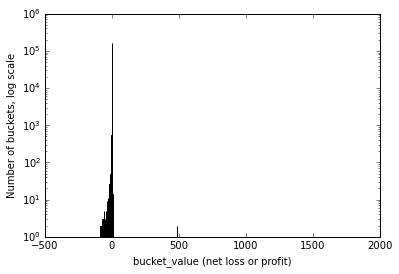

We see very few profitable buckets.


In [6]:
bucket_value = (1.5 * df.conversion - df.cost)
n, bins, patches = plt.hist(bucket_value, 1000, log=True)
plt.xlabel('bucket_value (net loss or profit)')
plt.ylabel('Number of buckets, log scale')
plt.show()
print('We see very few profitable buckets.')

In [7]:
# We can see that almost all buckets were lossy. Let’s look further: 
number_of_items = df.shape[0]
zero_clicks = df.click.value_counts()[0]
zero_conversion = df.conversion.value_counts()[0]

print("%.2f"% round(zero_clicks * 100 /number_of_items, 2), '% of the buckets had zero engagement (clicks=0).')
print("%.2f"% round((number_of_items - zero_conversion) * 100 / (number_of_items - zero_clicks), 2), 
      '% of the buckets with some engagement (clicks>0) lead to non-zero conversion.')
print('In total,', "%.2f"% round(df.conversion.sum() * 100/df.click.sum(), 2), '% of all clicks lead to a conversion.')  

93.69 % of the buckets had zero engagement (clicks=0).
18.98 % of the buckets with some engagement (clicks>0) lead to non-zero conversion.
In total, 11.05 % of all clicks lead to a conversion.


In [8]:
# Lets analyze the botom line (=conversion) distribution. 
print(df.conversion.describe(),'\n')
# print(df.conversion)
print('Skewness and kurtosis:')
print("Skewness: %f" % df['conversion'].skew())
print("Kurtosis: %f" % df['conversion'].kurt())
print('This Kurtosis')

count    172893.000000
mean          0.082103
std           5.319076
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1176.000000
Name: conversion, dtype: float64 

Skewness and kurtosis:
Skewness: 147.557009
Kurtosis: 26010.048520
This Kurtosis


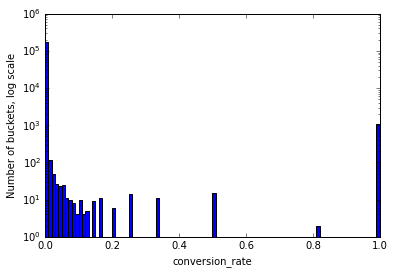

In [9]:
# I will define conversion_rate because it is better present the atractivness per bucket. 
conversion_rate = (df.conversion+0.001)/(df.impression+0.001)
n, bins, patches = plt.hist(conversion_rate, 100, log=True)
plt.xlabel('conversion_rate')
plt.ylabel('Number of buckets, log scale')
plt.show()

I add a small factor for the number of conversions. 
 Multypling the target price by this artificial conversion_rate will:
     1. eliminate the zeroing of ~98.3% of the conversion_rate. 
     2. increase price & chances to future win of <currently> low impressions.
     3. for very high impressions, this change will be negligible. 
  1. We can see the low engagement rates.

  2. I am not sure that: clicks > impression is a valid data.
     This might give us a price target > 1.5$. 

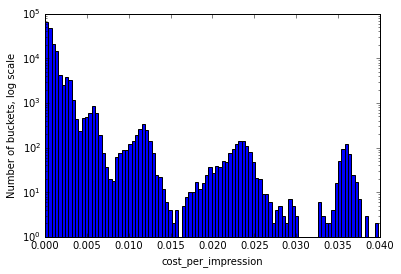

In [10]:
# Lets see the distribution of cost_per_impression (only the ones that won the bids).
cost_per_impression = df.cost/df.impression

n, bins, patches = plt.hist(cost_per_impression, 100, log=True)
plt.xlabel('cost_per_impression')
plt.ylabel('Number of buckets, log scale')
plt.show()

- By changing the price target (with this task), we want that future bids will have a starched cost_per_impression, according to the conversion_rate (per permutation) we learned from this data. 

# Preprocessing

#  Features selection

In [11]:
# Before doing one hot encoding, I want to see the quantity of uniques per categorical variable: 
df.astype('category').describe()

,publisher_id,tag_id,domain,device_os,device_type,creative_id,price_bucket,hour_category,bids,impression,click,landing,conversion,cost,day_category
count,172893,172893,172247,154705,153359.0,172893,172893.0,172893,172893,172893,172893,172893,172893,172893.0,172893
unique,2316,18855,6486,10,5.0,4,16.0,2,9473,3313,187,182,72,63964.0,2
top,4655,14259,weather.com,ios,4.0,433211,2.0,1,31,1,0,0,0,0.0,midweek
freq,11739,6258,7900,74295,82773.0,110228,24685.0,122083,3070,22598,161989,162588,170823,1046.0,108026


In [12]:
# “tag_id” is a categorical feature with very high cardinality. 
# I will not change it Because it is not ordinal, and lack of meaning, I prefer to remove it. 
# Before I remove this feature, I want to extract a new feature from it: hd (yes/no).
ext = df['tag_id'].str.split('_', expand=True)
ext = ext.where(ext[0] == 'hd', 'no_hd').drop(labels=1, axis=1)
df = pd.concat([df, ext], axis=1).rename(columns={0: 'hd'})
df = df.drop(columns =['tag_id']) 

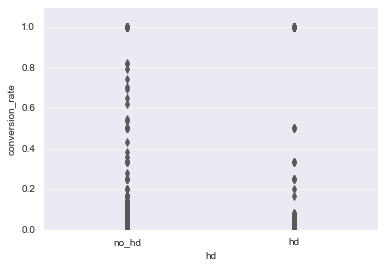

In [13]:
df['conversion_rate'] = conversion_rate
data = pd.concat([df['conversion_rate'], df['hd']], axis=1)
sns.set_style('darkgrid')
sns.set_palette('Set2')
f, ax = plt.subplots()
fig = sns.boxplot(x='hd', y='conversion_rate', whis=[0.5, 0.6], showfliers=True, data=data)
fig.axis(ymin=0, ymax=1.1)
plt.show()

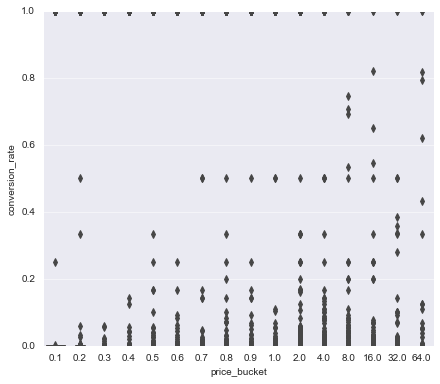

In [14]:
data = pd.concat([df['conversion_rate'], df['price_bucket']], axis=1)
# f, ax = plt.subplots()
plt.figure(figsize=(7,6))
fig = sns.boxplot(x='price_bucket', y='conversion_rate', data=data)
fig.axis(ymin=0, ymax=1)
plt.show()


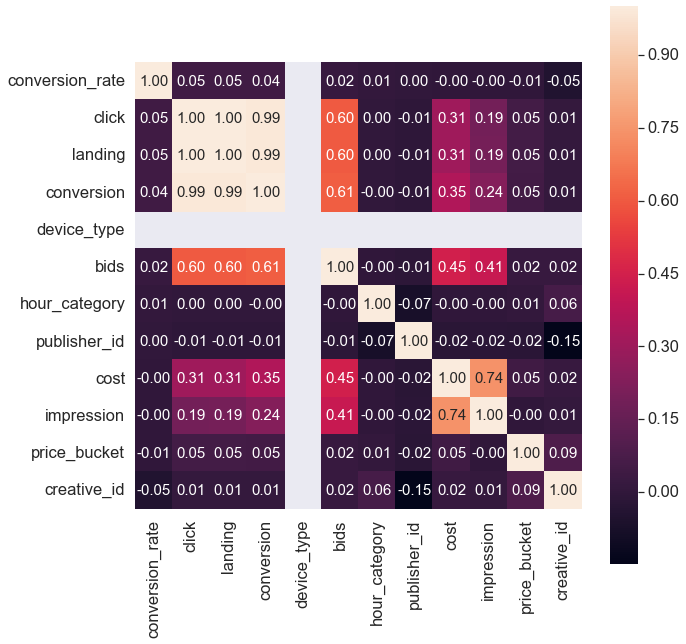

In [15]:
#  To verify that 'price_bucket' is not correlated to 'conversion_rate':
k = 12 #number of variables for heatmap
corrmat = df.corr()
cols = corrmat.nlargest(k, 'conversion_rate')['conversion_rate'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
plt.figure(figsize=(10,10))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

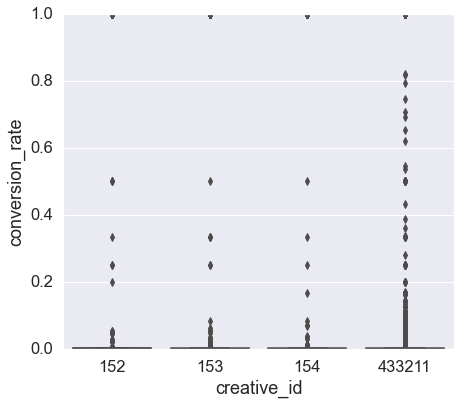

In [16]:
# It seems that creative_id has some inverse correlation with conversion_rate. 
data = pd.concat([df['conversion_rate'], df['creative_id']], axis=1)
plt.figure(figsize=(7,6))
fig = sns.boxplot(x='creative_id', y='conversion_rate', data=data)
fig.axis(ymin=0, ymax=1)
plt.show()


# Target:
We wish to maximaze the folowing factor:
net_income = bucket_value.sum() = (1.5 * df.conversion - df.cost).sum()
     

Paralele to this, we want to 
    1. increase wining rate for profitable buckets, 
    2. to give a chance to buckets with very low wining rate of bids. 
        Means, to optimize: 
            bids_wins_ratio = df.impression / df.bids

==========================================

I assume that RTB’s yield is influenced by:
-	External factors, such as other advertisers and their bids.
-	Hidden factors, such as if the end user already exposed to this ad.
-	Other (regular expenses, maintenance, commissions, etc.)

## For simplicity: 
We want to starch the target price ("best_price") with <at least> two factors:
- Increase price for attractive permutations (= high conversion_rate). 
- Increase price (= win chances) for "unsuccessful biddings" (= low impressions/bids) 
- Decrease price for very "successful biddings" (= high impressions/bids). 

The last two factors influenced by cost_per_impression. Therefor: 
My "best_price" will be the cost_per_impression, multiply by these two factors.
    target_price = conversion_rate * avarage_cost_per_impression * abs(log(impressions/bids))
    
### Please note: 
I don't have any data about the end user. 
I wish to use click_rate instead of conversion_rate.
    
**But:** 
Some permutations have clicks > impressions.
Therefor, I don't trust the click reliability (multiple clicks, disconnected ...)


In [17]:
print(conversion_rate.describe())

count    1.728930e+05
mean     6.612091e-03
std      7.852743e-02
min      1.139315e-08
25%      2.941090e-05
50%      9.090083e-05
75%      3.332223e-04
max      1.000000e+00
dtype: float64


In [18]:
conversion_rate.value_counts().sort_index()


1.139315e-08       1
2.044572e-08       1
2.129109e-08       1
2.346151e-08       1
2.542718e-08       1
                ... 
7.452637e-01       1
7.934786e-01       1
8.181846e-01       1
8.198769e-01       1
1.000000e+00    1061
Length: 4096, dtype: int64

In [19]:
# There is an option to starch the separation between good to bed conversion_rates:
# conversion_rate = conversion_rate**2

## bids_wins_ratio

It is not making sense to increase the bidding price by factors of 10^3 and more.
Therefor, I chouse to scale it logarithmically. 
The target_price will increase for bids_wins_ratio less than 0.36), 
and will decrease the target_price for very successful biddings (higher than 0.37). 
bids_wins_ratio = np.abs(np.log((df.impression + 1) / (df.bids + 1)))
I added 1 to both numerator and denominator, to avoid log(0) and inf values.

In [20]:
bids_wins_ratio = np.log((df.bids + 1) /(df.impression + 1))
# bids_wins_ratio = ((df.bids + 1) /(df.impression + 1))
# bwr_min = bids_wins_ratio.min()
# bwr_max = bids_wins_ratio.max()
# bids_wins_ratio = 3 * (bids_wins_ratio - bwr_min)/(bwr_max - bwr_min)
bids_wins_ratio.describe()

count    172893.000000
mean          2.282882
std           1.397566
min           0.000000
25%           1.163151
50%           2.140066
75%           3.135494
max          12.052356
dtype: float64

## cost_per_impression


In [21]:
# To avoid nans:
cost_per_impression = (df.cost + 10**-10) /(df.impression + 1)

The mean of original cost_per_impression was:
 0.0010638506212600441

The mean of the new target_priceis:
 2.7755100173729623e-05
This matches the majority of low conversion_rates we saw earlier


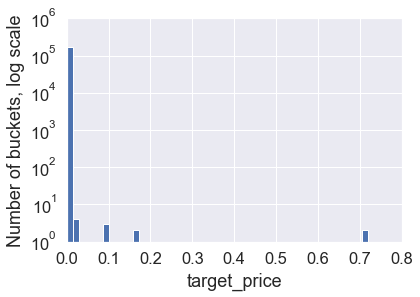

In [22]:
target_price = (cost_per_impression * 3 *conversion_rate * bids_wins_ratio + 10**-10)
print('The mean of original cost_per_impression was:\n', cost_per_impression.mean())
print('\nThe mean of the new target_priceis:\n', target_price.mean())
print('This matches the majority of low conversion_rates we saw earlier')
# Let's see the distribution of target_prices:
n, bins, patches = plt.hist(target_price, 50, log=True)
plt.xlabel('target_price')
plt.ylabel('Number of buckets, log scale')
plt.show()


1. We can see that for the magority, target_price is lower then original cost. 
    This reflects the low end-users engagement rate.
2. STD decreased. We want to saperete between "good buckts" to "bad buckets", but 98.3% of the date didn't gave any revnue, so this decrease is a good sign. 

Validate our metrix:

In [23]:
bucket_value = (1.5 * df.conversion - df.cost)
bucket_value_target = (1.5 * df.conversion - target_price * df.impression)
print('With the privious price bidding, we got net loss of:', bucket_value.sum())
print('With the new metric, we got net income of:', bucket_value_target.sum())

With the privious price bidding, we got net loss of: -15706.261459000001
With the new metric, we got net income of: 17572.744225652983


# Modeling

In [24]:
# Look for Nans: 
is_NaN = target_price.isnull()
is_NaN[is_NaN].index

Int64Index([], dtype='int64')

In [25]:
X_train, X_val, y_train, y_val = train_test_split(df, target_price, test_size=0.2)
model = CatBoostRegressor(iterations=20, learning_rate=0.3,depth=10, cat_features=['hd', 'publisher_id', 'domain', 'device_os', 'device_type', 'creative_id', 'hour_category', 'day_category'])
# Fit model:
X_train = X_train.drop(columns=['impression', 'bids', 'click', 'landing', 'conversion', 'cost', 'conversion_rate'])
X_train = X_train.astype('str')
model.fit(X_train, y_train)

0:	learn: 0.0028350	total: 208ms	remaining: 3.94s
1:	learn: 0.0026887	total: 257ms	remaining: 2.31s
2:	learn: 0.0025743	total: 311ms	remaining: 1.76s
3:	learn: 0.0025668	total: 404ms	remaining: 1.62s
4:	learn: 0.0024760	total: 508ms	remaining: 1.52s
5:	learn: 0.0023982	total: 616ms	remaining: 1.44s
6:	learn: 0.0023306	total: 721ms	remaining: 1.34s
7:	learn: 0.0022759	total: 828ms	remaining: 1.24s
8:	learn: 0.0022353	total: 935ms	remaining: 1.14s
9:	learn: 0.0022233	total: 1.04s	remaining: 1.04s
10:	learn: 0.0021449	total: 1.15s	remaining: 937ms
11:	learn: 0.0020829	total: 1.25s	remaining: 834ms
12:	learn: 0.0020232	total: 1.35s	remaining: 729ms
13:	learn: 0.0019309	total: 1.45s	remaining: 623ms
14:	learn: 0.0018677	total: 1.55s	remaining: 518ms
15:	learn: 0.0017957	total: 1.66s	remaining: 415ms
16:	learn: 0.0017655	total: 1.77s	remaining: 312ms
17:	learn: 0.0017512	total: 1.87s	remaining: 208ms
18:	learn: 0.0017190	total: 1.98s	remaining: 104ms
19:	learn: 0.0017133	total: 2.08s	remaini

# Results
- Use the next cell to perform your analysis.
- report the results and present them verbaly and graphically. 

note: here you should describe both the model validation score (how you know the model is good) and the prediction validation  score (how you know the prediction is good). 

In [26]:
# Get prediction: 
X_val_impression = X_val.impression.copy()
X_val_conversion = X_val.conversion.copy()
X_val_cost = X_val.cost.copy()
X_val = X_val.drop(columns=['impression', 'bids', 'click', 'landing', 'conversion', 'cost', 'conversion_rate'])
X_val = X_val.astype('str')
pred = model.predict(X_val)


In [27]:
errors_vec = y_val-pred
err = pd.DataFrame(errors_vec)
err.describe()

,0
count,3.457900e+04
mean,2.477516e-05
std,3.667464e-03
min,-5.308363e-02
25%,-3.451275e-06
50%,-8.825563e-07
75%,1.809794e-06
max,5.705460e-01


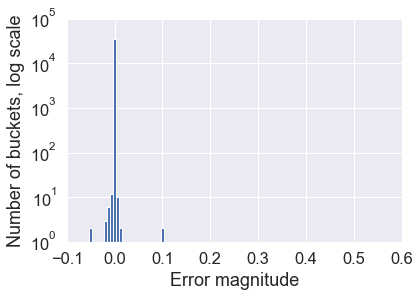

In [28]:
n, bins, patches = plt.hist(err, 100, log=True)
plt.xlabel('Error magnitude')
plt.ylabel('Number of buckets, log scale')
plt.show()

### The error seams to be reasonable:
- Smaller than most of cost_per_instance. 
- Centered  around zero.

In [29]:
original_bucket_value = (1.5 * X_val_conversion - X_val_cost)
bucket_value_pred = (1.5 * X_val_conversion - pred * X_val_impression)
print('Summary for the valuation set: \n- Income for the val set:', (1.5 * X_val_conversion).sum())
print('- Original prices Net loss/income:', original_bucket_value.sum())
print('- New metric Net loss/income:', bucket_value_pred.sum())
print('\n==============\nAt the valuation set, we save', "%.2f"% round(bucket_value_pred.sum()*100 / (1.5 * X_val_conversion).sum(), 2), '% of the available income.')

Summary for the valuation set: 
- Income for the val set: 4713.0
- Original prices Net loss/income: -1895.7525389999996
- New metric Net loss/income: 4567.197138468527

At the valuation set, we save 96.91 % of the available income.


# Conclusion:
- At the valuation stage, we increased the income to almost its maximal. 
- Nevertheless, our metric takes into account not winning the bidding, and increase the bidding price accordingly. (up to 12 times higher). 
